# 1.Imaging a Point Cloud Using a Camera Consructed by Specifying Extrinsic and Intrinsic Parameters

geometry::PointCloud with 1335 points.
(1335, 3)
[[  896.994     48.7601 -3917.7344]
 [  906.593     48.7601 -3919.2548]
 [  907.539     55.4902 -3916.3419]
 ...
 [  806.665    627.363  -3994.8852]
 [  806.665    654.432  -3992.48  ]
 [  806.665    681.537  -3990.5126]]


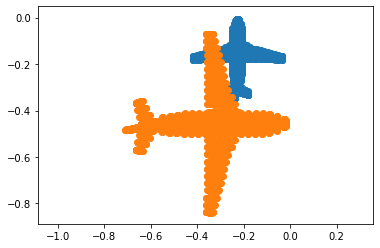

In [13]:
# https://people.sc.fsu.edu/~jburkardt/data/ply/ply.html
#https://stackoverflow.com/questions/50965673/python-display-3d-point-cloud

#%matplotlib inline
import numpy as np
import open3d as o3d
import numpy.matlib
import scipy
import scipy.optimize
import matplotlib.pyplot as plt

pcd = o3d.io.read_point_cloud("airplane.ply") # Read the point cloud
print(pcd)
points = np.asarray(pcd.points)
# points = points[0:5, :]
print(points.shape)
o3d.visualization.draw_geometries([pcd])
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
# ax.scatter(points[:,0], points[:,1])

ones = np.ones((points.shape[0], 1))
points = np.concatenate((points, ones), axis=1)

P = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.]])

# Rotation matrix R is an orthonormal marix
R = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
K = np.array([[1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.]])
t = np.array([[0.],
              [0.],
              [-4000.]])
P1 = np.matmul(K, np.concatenate((R, t), axis=1))# P = K[R|t] = K[R|-RC]

R = np.array([[0., 1., 0.],
              [1., 0., 0.],
              [0., 0., 1.]])
K = np.array([[2., 0., 0.],
              [0., 2., 0.],
              [0., 0., 1.]])
P2 = np.matmul(K, np.concatenate((R, t), axis=1))

transfromed = np.matmul(P1, points.T).T
print(transfromed)
transfromed = transfromed/np.matlib.repmat(transfromed[:,2], 3, 1).T
ax.scatter(transfromed[:,0], transfromed[:,1])

transfromed = np.matmul(P2, points.T).T
transfromed = transfromed/np.matlib.repmat(transfromed[:,2], 3, 1).T
ax.scatter(transfromed[:,0], transfromed[:,1])
ax.axis('equal')
plt.show()

In [14]:
np.set_printoptions(precision=4)
print('P1\n', P1)
print('P2\n', P2)

P1
 [[ 1.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  1.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  1.e+00 -4.e+03]]
P2
 [[ 0.e+00  2.e+00  0.e+00  0.e+00]
 [ 2.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  1.e+00 -4.e+03]]


# 2.Recovering K, R, and C

In [15]:
# RQ Decomposition
# http://ksimek.github.io/2012/08/14/decompose/
def rq(M):
  Q, R = np.linalg.qr(np.flipud(M).T)
# print(Q)
# print(R)
  R = np.flipud(R.T)
  R = np.fliplr(R)
  Q = Q.T;
  Q = np.flipud(Q)
  return R, Q

In [16]:
# P = [M|-MC]
# P = K[R|-RC]
M = P2[:, 0:3]
C = np.linalg.inv(M)@P1[:,3] # camera center in world coordinates
K, R = rq(M)
K, R = scipy.linalg.rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)));

K = K @ T;
R = T @ R; # (T is its own inverse)
print(K)
print(R)

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [17]:
# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)));
K = K @ T;
R = T @ R; # (T is its own inverse)
print(K)
print(R)

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [18]:
# P from Hartley and Zisserman Example 6.2
Phz = np.array(
    [[3.53553e+2, 3.39645e+2, 2.77744e+2, -1.44946e+6],
     [-1.03528e+2, 2.33212e+1, 4.59607e+2, -6.32525e+5],
     [7.07107e-1, -3.53553e-1, 6.12372e-1, -9.18559e+2]])

In [19]:
# P = [M|-MC]
# P = K[R|-RC]
M = Phz[:, 0:3]
C = -np.linalg.inv(M)@Phz[:,3] # camera center in world coordinates
K, R = rq(M)
K, R = scipy.linalg.rq(M)

# make diagonal of K positive
T = np.diag(np.sign(np.diag(K)));

K = K @ T;
R = T @ R; # (T is its own inverse)
print(C)
print(K)
print(R)

[1000.0007 2000.002  1500.0003]
[[468.1647  91.2251 300.    ]
 [  0.     427.2009 199.9999]
 [  0.       0.       1.    ]]
[[ 0.4138  0.9091  0.0471]
 [-0.5734  0.2201  0.7892]
 [ 0.7071 -0.3536  0.6124]]


# SVD Test

In [20]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
U, S, V = np.linalg.svd(A)

In [21]:
S

array([1.6848e+01, 1.0684e+00, 3.3348e-16])